In [122]:
from stompy.grid import unstructured_grid
from stompy import utils
from stompy.model.suntans import sun_driver
import os
from matplotlib import colors

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import stompy.plot.cmap as scmap

In [111]:
%matplotlib notebook

In [37]:
dir(colors)

['BASE_COLORS',
 'BoundaryNorm',
 'CSS4_COLORS',
 'ColorConverter',
 'Colormap',
 'LightSource',
 'LinearSegmentedColormap',
 'ListedColormap',
 'LogNorm',
 'NoNorm',
 'Normalize',
 'PowerNorm',
 'Sized',
 'SymLogNorm',
 'TABLEAU_COLORS',
 'XKCD_COLORS',
 '_ColorMapping',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_colors_full_map',
 '_is_nth_color',
 '_sanitize_extrema',
 '_to_rgba_no_colorcycle',
 '_vector_magnitude',
 'cbook',
 'cnames',
 'colorConverter',
 'from_levels_and_colors',
 'get_named_colors_mapping',
 'hex2color',
 'hexColorPattern',
 'hsv_to_rgb',
 'is_color_like',
 'itertools',
 'makeMappingArray',
 'np',
 're',
 'rgb2hex',
 'rgb_to_hsv',
 'same_color',
 'to_hex',
 'to_rgb',
 'to_rgba',
 'to_rgba_array']

In [6]:
model=sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_007-20170701/")
g=model.grid

INFO:DFlowModel:Will read cell depths, too
INFO:UnstructuredGrid:Will flip 0 edges


In [118]:
# (s^d-1)/(s-1)

class SaltNorm(colors.Normalize):
    alpha=10.0
    def __call__(self,value,clip=True):
        lin_norm=super(SaltNorm,self).__call__(value,clip)
        return lin_norm**self.alpha
    def inverse(self,value):
        value=value**(1./self.alpha)
        lin_inv=super(SaltNorm,self).inverse(value)
        return lin_inv        

class SkewNorm(colors.Normalize):
    skew=500.0
    def __call__(self,value,clip=True):
        x=super(SkewNorm,self).__call__(value,clip)
        if self.skew!=1.0:
            x=(self.skew**x-1)/(self.skew-1)
        return x
    def inverse(self,value):
        if self.skew!=1.0:
            value=np.log(value*(self.skew-1)+1)/np.log(self.skew)
        return super(SkewNorm,self).inverse(value)


In [115]:
s_cmap=scmap.load_gradient("ncview_banded.cpt")
s_cmap=scmap.cmap_clip(s_cmap,0,0.9) # avoid purple on high end
t_cmap=scmap.load_gradient('hot_desaturated.cpt')

<IPython.core.display.Javascript object>


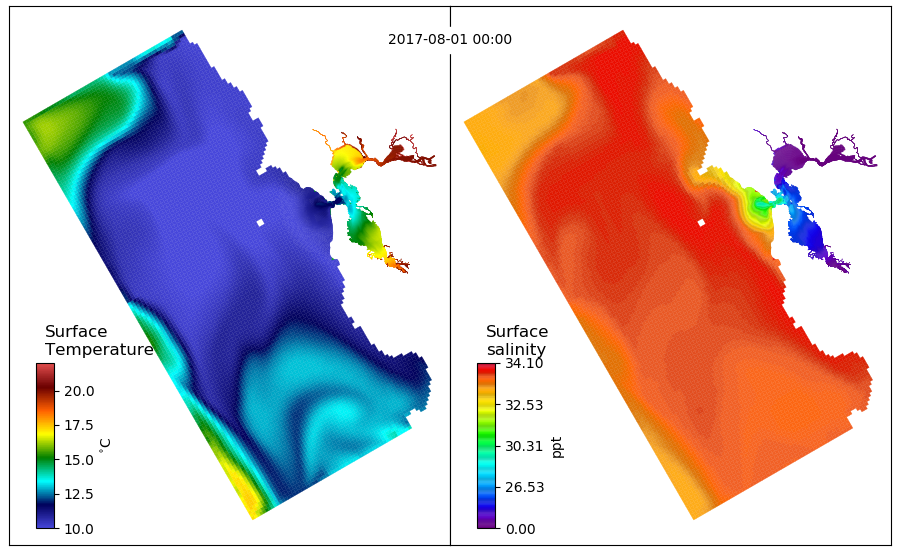

In [116]:
fig=plt.figure(figsize=(9,5.5))

In [136]:
def plot_step(fig,map_ds_step):
    # looks like rho is not reliable, maybe because
    # it is computed at a different time?
    # use temperature to decide which cells are wet.
    rho=map_ds_step.temp.values
    rho[np.isnan(rho)]=0.0
    wet_3d=rho>0.0
    wet_2d=np.any(wet_3d,axis=0)
    ctop=np.argmax(wet_3d,axis=0)

    def inset_ax(ax):
        pos=ax.get_position()
        return fig.add_axes([pos.xmin+0.03,pos.ymin+0.03,
                             0.02,0.3])
    
    fig.clf()
    ax_temp=fig.add_subplot(1,2,1)
    ax_salt=fig.add_subplot(1,2,2)

    fig.subplots_adjust(left=0.01,right=0.99,top=0.99,bottom=0.01,wspace=0)

    cax_temp=inset_ax(ax_temp)
    cax_salt=inset_ax(ax_salt)

    for ax in [ax_temp,ax_salt]:
        ax.xaxis.set_visible(0)
        ax.yaxis.set_visible(0)

    cells=np.arange(g.Ncells())
    surf_temp=map_ds_step.temp.values[ctop,cells]
    tcoll=g.plot_cells(ax=ax_temp,values=surf_temp,cmap='jet',mask=wet_2d,lw=0.2)


    surf_salt=map_ds_step.salt.values[ctop,cells]
    scoll=g.plot_cells(ax=ax_salt,values=surf_salt,cmap='jet',mask=wet_2d,lw=0.2,
                      norm=SkewNorm())

    ax_temp.axis('equal')
    ax_salt.axis('equal')

    tcoll.set_edgecolor('face')
    tcoll.set_cmap(t_cmap)
    tcoll.set_clim([10,22])

    scoll.set_edgecolor('face')
    scoll.set_cmap(s_cmap)
    scoll.set_clim([0,34.1])

    tcbar=plt.colorbar(tcoll,cax=cax_temp,label="$^{\circ}$C")
    cax_temp.set_title("Surface\nTemperature")
    scbar=plt.colorbar(scoll,cax=cax_salt,label="ppt")
    cax_salt.set_title("Surface\nsalinity")

    # Account for skew scale
    ticks=scoll.norm.inverse(np.linspace(0,1,5))
    scbar.set_ticks(ticks)

    plt.setp(cax_temp.title,ha='left')
    plt.setp(cax_salt.title,ha='left')

    time_str=utils.to_datetime(map_ds_step.time.values).strftime("%Y-%m-%d %H:%M")
    print(time_str)
    fig.text(0.5,0.92,time_str,ha='center',zorder=10,bbox=dict(color='w'))

In [140]:
frame_dir="salt_temp_frames_00"
os.path.exists(frame_dir) or os.makedirs(frame_dir)

maps=model.map_outputs()

frame=0

for fn in maps: 
    map_ds=xr.open_dataset(fn)
    for tidx in range(len(map_ds.time)):
        img_fn=os.path.join(frame_dir,"frame%04d.png"%frame)
        frame+=1
        if os.path.exists(img_fn): continue        
        map_ds_step=map_ds.isel(time=tidx)
        plot_step(fig,map_ds_step)
        fig.savefig(img_fn)

    map_ds.close()


2017-07-11 00:00
2017-07-11 00:30
2017-07-11 01:00
2017-07-11 01:30
2017-07-11 02:00
2017-07-11 02:30
2017-07-11 03:00
2017-07-11 03:30
2017-07-11 04:00
2017-07-11 04:30
2017-07-11 05:00
2017-07-11 05:30
2017-07-11 06:00
2017-07-11 06:30
2017-07-11 07:00
2017-07-11 07:30
2017-07-11 08:00
2017-07-11 08:30
2017-07-11 09:00
2017-07-11 09:30
2017-07-11 10:00
2017-07-11 10:30
2017-07-11 11:00
2017-07-11 11:30
2017-07-11 12:00
2017-07-11 12:30
2017-07-11 13:00
2017-07-11 13:30
2017-07-11 14:00
2017-07-11 14:30
2017-07-11 15:00
2017-07-11 15:30
2017-07-11 16:00
2017-07-11 16:30
2017-07-11 17:00
2017-07-11 17:30
2017-07-11 18:00
2017-07-11 18:30
2017-07-11 19:00
2017-07-11 19:30
2017-07-11 20:00
2017-07-11 20:30
2017-07-11 21:00
2017-07-11 21:30
2017-07-11 22:00
2017-07-11 22:30
2017-07-11 23:00
2017-07-11 23:30
2017-07-12 00:00
2017-07-12 00:30
2017-07-12 01:00
2017-07-12 01:30
2017-07-12 02:00
2017-07-12 02:30
2017-07-12 03:00
2017-07-12 03:30
2017-07-12 04:00
2017-07-12 04:30
2017-07-12 05:

2017-07-21 01:00
2017-07-21 01:30
2017-07-21 02:00
2017-07-21 02:30
2017-07-21 03:00
2017-07-21 03:30
2017-07-21 04:00
2017-07-21 04:30
2017-07-21 05:00
2017-07-21 05:30
2017-07-21 06:00
2017-07-21 06:30
2017-07-21 07:00
2017-07-21 07:30
2017-07-21 08:00
2017-07-21 08:30
2017-07-21 09:00
2017-07-21 09:30
2017-07-21 10:00
2017-07-21 10:30
2017-07-21 11:00
2017-07-21 11:30
2017-07-21 12:00
2017-07-21 12:30
2017-07-21 13:00
2017-07-21 13:30
2017-07-21 14:00
2017-07-21 14:30
2017-07-21 15:00
2017-07-21 15:30
2017-07-21 16:00
2017-07-21 16:30
2017-07-21 17:00
2017-07-21 17:30
2017-07-21 18:00
2017-07-21 18:30
2017-07-21 19:00
2017-07-21 19:30
2017-07-21 20:00
2017-07-21 20:30
2017-07-21 21:00
2017-07-21 21:30
2017-07-21 22:00
2017-07-21 22:30
2017-07-21 23:00
2017-07-21 23:30
2017-07-22 00:00
2017-07-22 00:30
2017-07-22 01:00
2017-07-22 01:30
2017-07-22 02:00
2017-07-22 02:30
2017-07-22 03:00
2017-07-22 03:30
2017-07-22 04:00
2017-07-22 04:30
2017-07-22 05:00
2017-07-22 05:30
2017-07-22 06:

2017-07-31 02:00
2017-07-31 02:30
2017-07-31 03:00
2017-07-31 03:30
2017-07-31 04:00
2017-07-31 04:30
2017-07-31 05:00
2017-07-31 05:30
2017-07-31 06:00
2017-07-31 06:30
2017-07-31 07:00
2017-07-31 07:30
2017-07-31 08:00
2017-07-31 08:30
2017-07-31 09:00
2017-07-31 09:30
2017-07-31 10:00
2017-07-31 10:30
2017-07-31 11:00
2017-07-31 11:30
2017-07-31 12:00
2017-07-31 12:30
2017-07-31 13:00
2017-07-31 13:30
2017-07-31 14:00
2017-07-31 14:30
2017-07-31 15:00
2017-07-31 15:30
2017-07-31 16:00
2017-07-31 16:30
2017-07-31 17:00
2017-07-31 17:30
2017-07-31 18:00
2017-07-31 18:30
2017-07-31 19:00
2017-07-31 19:30
2017-07-31 20:00
2017-07-31 20:30
2017-07-31 21:00
2017-07-31 21:30
2017-07-31 22:00
2017-07-31 22:30
2017-07-31 23:00
2017-07-31 23:30
2017-08-01 00:00
